[0]	train-auc:0.98784	test-auc:0.98558
[50]	train-auc:0.99995	test-auc:0.99985
[100]	train-auc:0.99999	test-auc:0.99994
[150]	train-auc:1.00000	test-auc:0.99997
[200]	train-auc:1.00000	test-auc:0.99997
[250]	train-auc:1.00000	test-auc:0.99997
[300]	train-auc:1.00000	test-auc:0.99997
[350]	train-auc:1.00000	test-auc:0.99997
[400]	train-auc:1.00000	test-auc:0.99997
[409]	train-auc:1.00000	test-auc:0.99997

Test AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8198
           1       0.99      1.00      1.00      1802

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


Optimal threshold: 0.5232

Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8198
           1       0.99      1.00      1.00 

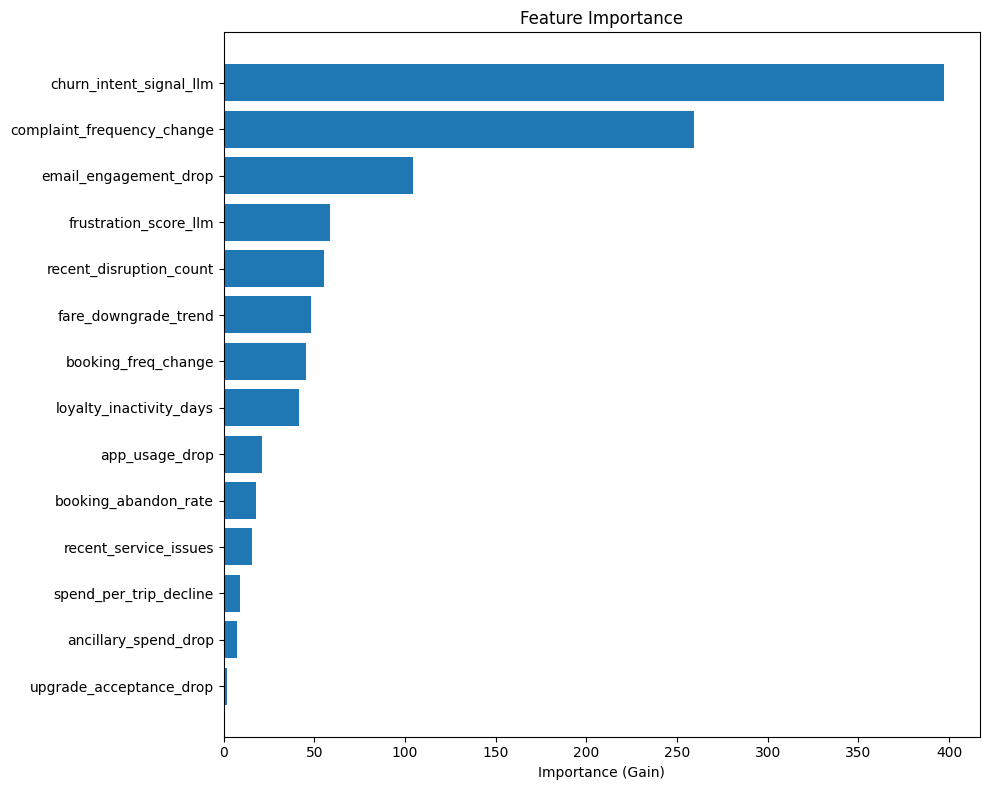


Top 10 Features:
                       feature  importance
13     churn_intent_signal_llm  397.141815
12  complaint_frequency_change  259.114594
6        email_engagement_drop  104.380013
11       frustration_score_llm   58.338264
3      recent_disruption_count   55.434006
1         fare_downgrade_trend   48.346054
0          booking_freq_change   45.443142
7      loyalty_inactivity_days   41.620605
5               app_usage_drop   20.952671
2         booking_abandon_rate   17.921827
Fold 1 AUC: 1.0000
Fold 2 AUC: 0.9999
Fold 3 AUC: 1.0000
Fold 4 AUC: 1.0000
Fold 5 AUC: 1.0000

CV Mean AUC: 1.0000 (+/- 0.0000)

Model saved to xgb_churn_model.json

Sample Predictions:
    actual  predicted_proba  predicted_class
0        1     9.962085e-01                1
1        0     1.410002e-05                0
2        0     3.341014e-06                0
3        1     9.999623e-01                1
4        0     6.719621e-07                0
5        0     1.662089e-04                0
6      

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('airline_synthetic_50000.csv')

feature_cols = [
    'booking_freq_change', 'fare_downgrade_trend', 'booking_abandon_rate',
    'recent_disruption_count', 'recent_service_issues', 'lounge_access_issues',
    'app_usage_drop', 'email_engagement_drop', 'loyalty_inactivity_days',
    'ancillary_spend_drop', 'upgrade_acceptance_drop', 'spend_per_trip_decline',
    'frustration_score_llm', 'complaint_frequency_change', 'churn_intent_signal_llm'
]

X = df[feature_cols]
y = df['churn_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

y_pred_proba = model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'\nTest AUC: {auc_score:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f'\nOptimal threshold: {optimal_threshold:.4f}')

y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
print('\nClassification Report (Optimal Threshold):')
print(classification_report(y_test, y_pred_optimal))

importance = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance (Gain)')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nTop 10 Features:')
print(importance_df.head(10))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    dtrain_fold = xgb.DMatrix(X_fold_train, label=y_fold_train)
    dval_fold = xgb.DMatrix(X_fold_val, label=y_fold_val)
    
    model_fold = xgb.train(
        params,
        dtrain_fold,
        num_boost_round=500,
        evals=[(dval_fold, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    y_val_pred = model_fold.predict(dval_fold)
    fold_auc = roc_auc_score(y_fold_val, y_val_pred)
    cv_scores.append(fold_auc)
    print(f'Fold {fold} AUC: {fold_auc:.4f}')

print(f'\nCV Mean AUC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})')

model.save_model('xgb_churn_model.json')
print('\nModel saved to xgb_churn_model.json')

sample_predictions = pd.DataFrame({
    'actual': y_test[:20].values,
    'predicted_proba': y_pred_proba[:20],
    'predicted_class': y_pred_optimal[:20]
})
print('\nSample Predictions:')
print(sample_predictions)

Model Evaluation Results

AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

    Retained       1.00      0.98      0.99        57
     Churned       0.98      1.00      0.99        43

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[56  1]
 [ 0 43]]


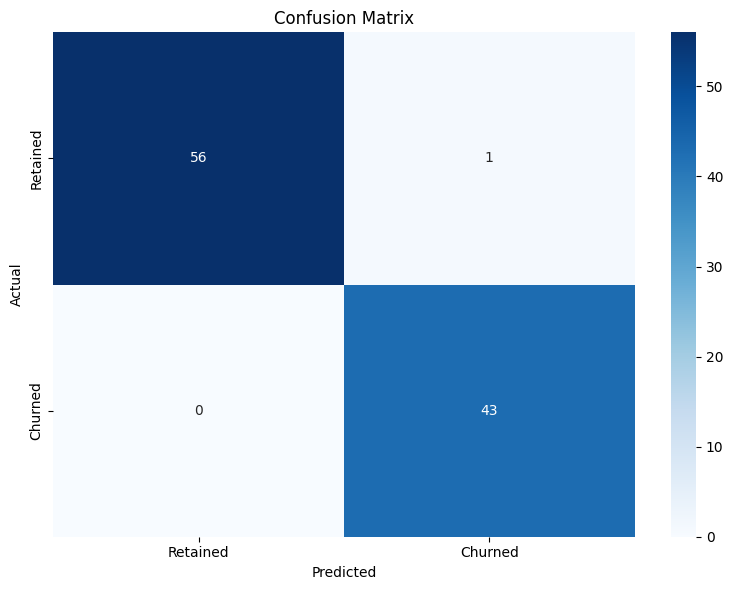

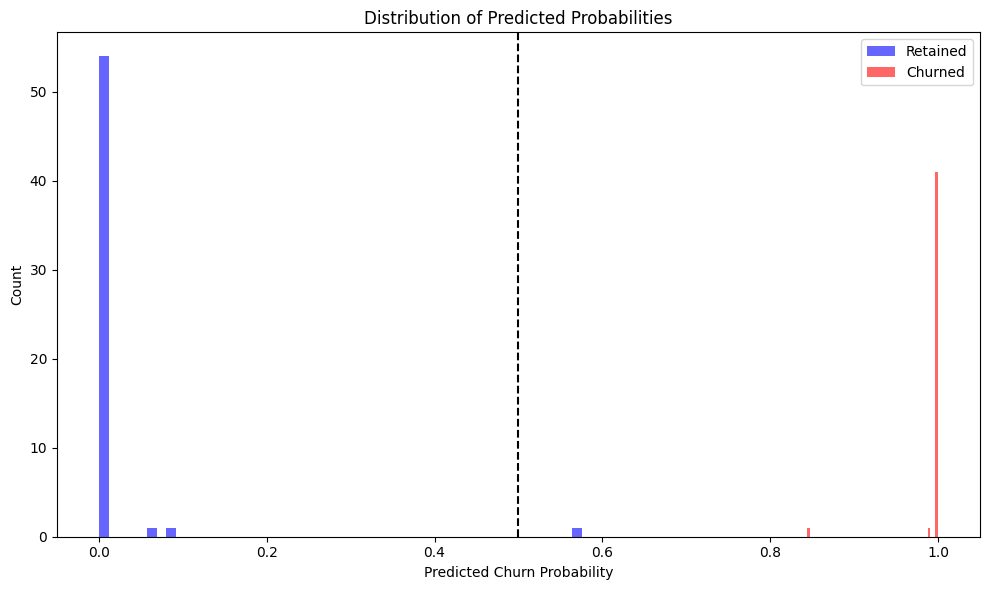


Predictions saved to churn_predictions.csv

Sample High Risk Customers:
    customer_id  predicted_proba  actual_churn
3       1000003         0.999992             1
4       1000004         0.987751             1
11      1000011         0.999364             1
12      1000012         0.999964             1
13      1000013         0.999855             1
16      1000016         0.998238             1
17      1000017         0.999890             1
19      1000019         0.999997             1
21      1000021         0.999827             1
22      1000022         0.999984             1

Risk Distribution:
risk_category
Low Risk       56
High Risk      43
Medium Risk     1
Name: count, dtype: int64

Churn Rate by Risk Category:
               mean  count
risk_category             
Low Risk        0.0     56
Medium Risk     0.0      1
High Risk       1.0     43


/var/folders/17/t6z9crsn70qgz06c_f16m99h0000gt/T/ipykernel_4994/2715766217.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_risk = results_df.groupby('risk_category')['actual_churn'].agg(['mean', 'count'])


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model = xgb.Booster()
model.load_model('xgb_churn_model.json')

df_test = pd.read_csv('airline_synthetic_test.csv')

feature_cols = [
    'booking_freq_change', 'fare_downgrade_trend', 'booking_abandon_rate',
    'recent_disruption_count', 'recent_service_issues', 'lounge_access_issues',
    'app_usage_drop', 'email_engagement_drop', 'loyalty_inactivity_days',
    'ancillary_spend_drop', 'upgrade_acceptance_drop', 'spend_per_trip_decline',
    'frustration_score_llm', 'complaint_frequency_change', 'churn_intent_signal_llm'
]

X_test = df_test[feature_cols]
y_test = df_test['churn_label']

dtest = xgb.DMatrix(X_test)
y_pred_proba = model.predict(dtest)

optimal_threshold = 0.5
y_pred = (y_pred_proba > optimal_threshold).astype(int)

print("Model Evaluation Results")
print("=" * 50)

auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'\nAUC Score: {auc_score:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Retained', 'Churned']))

cm = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix:')
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[y_test==0], bins=50, alpha=0.6, label='Retained', color='blue')
plt.hist(y_pred_proba[y_test==1], bins=50, alpha=0.6, label='Churned', color='red')
plt.xlabel('Predicted Churn Probability')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.axvline(x=optimal_threshold, color='black', linestyle='--', label=f'Threshold: {optimal_threshold}')
plt.tight_layout()
plt.savefig('probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

results_df = pd.DataFrame({
    'customer_id': df_test['customer_id'],
    'actual_churn': y_test,
    'predicted_proba': y_pred_proba,
    'predicted_churn': y_pred,
    'risk_category': pd.cut(y_pred_proba, 
                            bins=[0, 0.3, 0.7, 1.0], 
                            labels=['Low Risk', 'Medium Risk', 'High Risk'])
})

results_df.to_csv('churn_predictions.csv', index=False)
print('\nPredictions saved to churn_predictions.csv')

print('\nSample High Risk Customers:')
high_risk = results_df[results_df['predicted_proba'] > 0.7].head(10)
print(high_risk[['customer_id', 'predicted_proba', 'actual_churn']])

print('\nRisk Distribution:')
print(results_df['risk_category'].value_counts())

print('\nChurn Rate by Risk Category:')
churn_by_risk = results_df.groupby('risk_category')['actual_churn'].agg(['mean', 'count'])
print(churn_by_risk)


Model Evaluation Results

AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

    Retained       1.00      0.98      0.99        57
     Churned       0.98      1.00      0.99        43

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[56  1]
 [ 0 43]]

Predictions saved to churn_predictions.csv

Sample High Risk Customers:
    customer_id  predicted_proba  actual_churn
3       1000003         0.999992             1
4       1000004         0.987751             1
11      1000011         0.999364             1
12      1000012         0.999964             1
13      1000013         0.999855             1
16      1000016         0.998238             1
17      1000017         0.999890             1
19      1000019         0.999997             1
21      1000021         0.999827             1
22      1000022         

/var/folders/17/t6z9crsn70qgz06c_f16m99h0000gt/T/ipykernel_4994/2915054424.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_risk = results_df.groupby('risk_category')['actual_churn']


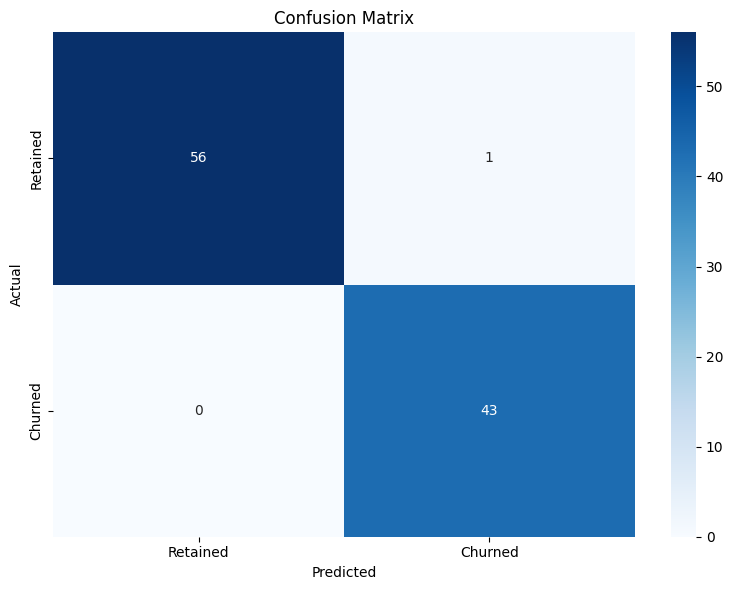

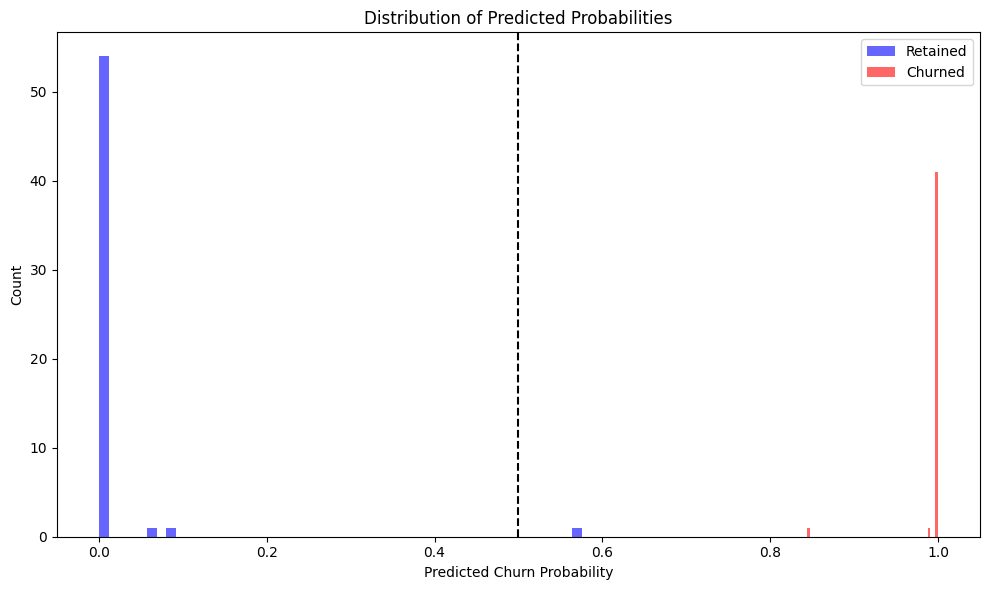

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model = xgb.Booster()
model.load_model('xgb_churn_model.json')

df_test = pd.read_csv('airline_synthetic_test.csv')

feature_cols = [
    'booking_freq_change', 'fare_downgrade_trend', 'booking_abandon_rate',
    'recent_disruption_count', 'recent_service_issues', 'lounge_access_issues',
    'app_usage_drop', 'email_engagement_drop', 'loyalty_inactivity_days',
    'ancillary_spend_drop', 'upgrade_acceptance_drop', 'spend_per_trip_decline',
    'frustration_score_llm', 'complaint_frequency_change', 'churn_intent_signal_llm'
]

X_test = df_test[feature_cols]
y_test = df_test['churn_label']

dtest = xgb.DMatrix(X_test)
y_pred_proba = model.predict(dtest)

optimal_threshold = 0.5
y_pred = (y_pred_proba > optimal_threshold).astype(int)

print("Model Evaluation Results")
print("=" * 50)

auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'\nAUC Score: {auc_score:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Retained', 'Churned']))

cm = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix:')
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[y_test==0], bins=50, alpha=0.6, label='Retained', color='blue')
plt.hist(y_pred_proba[y_test==1], bins=50, alpha=0.6, label='Churned', color='red')
plt.xlabel('Predicted Churn Probability')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.axvline(x=optimal_threshold, color='black', linestyle='--', label=f'Threshold: {optimal_threshold}')
plt.tight_layout()
plt.savefig('probability_distribution.png', dpi=300, bbox_inches='tight')

# --- MODIFIED CODE BLOCK START ---
# Select customer_id, all features, and the actual churn label from the test set
results_df = df_test[['customer_id'] + feature_cols + ['churn_label']].copy()
# Rename 'churn_label' to 'actual_churn' for consistency with original output
results_df = results_df.rename(columns={'churn_label': 'actual_churn'})

# Add the prediction results
results_df['predicted_proba'] = y_pred_proba
results_df['predicted_churn'] = y_pred
results_df['risk_category'] = pd.cut(y_pred_proba, 
                            bins=[0, 0.3, 0.7, 1.0], 
                            labels=['Low Risk', 'Medium Risk', 'High Risk'])
# --- MODIFIED CODE BLOCK END ---

results_df.to_csv('churn_predictions.csv', index=False)
print('\nPredictions saved to churn_predictions.csv')

print('\nSample High Risk Customers:')
high_risk = results_df[results_df['predicted_proba'] > 0.7].head(10)
print(high_risk[['customer_id', 'predicted_proba', 'actual_churn']])

print('\nRisk Distribution:')
print(results_df['risk_category'].value_counts())

print('\nChurn Rate by Risk Category:')
churn_by_risk = results_df.groupby('risk_category')['actual_churn']